Epoch 1/10, Loss: 0.0634
Epoch 2/10, Loss: 0.0245
Epoch 3/10, Loss: 0.0110
Epoch 4/10, Loss: 0.0062
Epoch 5/10, Loss: 0.0026
Epoch 6/10, Loss: 0.0021
Epoch 7/10, Loss: 0.0025
Epoch 8/10, Loss: 0.0012
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0001


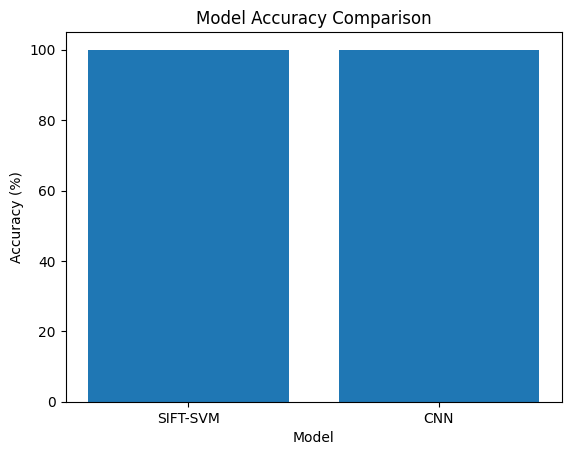

Model Accuracies:
SIFT-SVM: 99.85%
CNN: 100.00%


In [7]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt

# 1️⃣ Data Preparation
class BarcodeQRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        class_0_dir = os.path.join(root_dir, 'barcode', '0')
        class_1_dir = os.path.join(root_dir, 'barcode', '1')
        qr_dir = os.path.join(root_dir, 'qrcode', 'qr_dataset')
        
        for img_name in os.listdir(class_0_dir):
            if img_name.endswith('.png'):
                self.image_paths.append(os.path.join(class_0_dir, img_name))
                self.labels.append(0)  # Product label
        
        for img_name in os.listdir(class_1_dir):
            if img_name.endswith('.png'):
                self.image_paths.append(os.path.join(class_1_dir, img_name))
                self.labels.append(1)  # Barcode label
        
        for img_name in os.listdir(qr_dir):
            if img_name.endswith('.png'):
                self.image_paths.append(os.path.join(qr_dir, img_name))
                self.labels.append(2)  # QR Code label
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Dataset
dataset = BarcodeQRDataset(root_dir='../Dataset/', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2️⃣ SIFT + SVM Model (Traditional ML)
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

def prepare_sift_svm_data(root_dir):
    descriptors_list = []
    labels = []
    
    class_dirs = [
        (os.path.join(root_dir, 'barcode', '0'), 0),
        (os.path.join(root_dir, 'barcode', '1'), 1),
        (os.path.join(root_dir, 'qrcode', 'qr_dataset'), 2)
    ]
    
    for dir_path, label in class_dirs:
        for img_name in os.listdir(dir_path):
            if img_name.endswith('.png'):
                img_path = os.path.join(dir_path, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                descriptors = extract_sift_features(image)
                if descriptors is not None:
                    descriptors_list.append(descriptors.mean(axis=0))
                    labels.append(label)
    
    return np.array(descriptors_list), np.array(labels)

X_train, y_train = prepare_sift_svm_data('../Dataset/')
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
svm.fit(X_train, y_train)
svm_accuracy = svm.score(X_train, y_train) * 100

# 3️⃣ Simple CNN (Baseline Deep Learning Model)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 3)  # Product vs Barcode vs QR Code
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train CNN
cnn = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Evaluate CNN Accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloader:
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_accuracy = (correct / total) * 100

# Print and Plot Accuracies
accuracies = {'SIFT-SVM': svm_accuracy, 'CNN': cnn_accuracy}

plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.show()

print("Model Accuracies:")
for model, acc in accuracies.items():
    print(f"{model}: {acc:.2f}%")


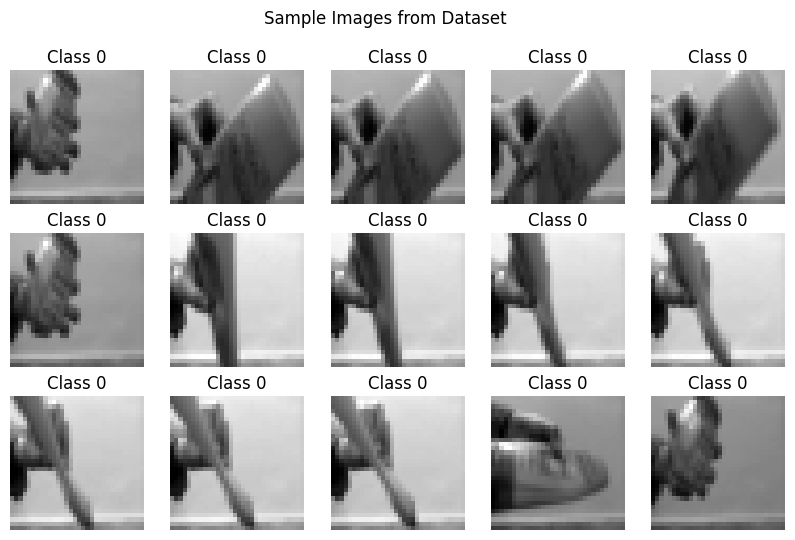

In [11]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle("Sample Images from Dataset")
for i, ax in enumerate(axes.flat):
    image, label = dataset[i]
    ax.imshow(image.squeeze(),cmap='gray')
    ax.set_title(f'Class {label}')
    ax.axis('off')
plt.show()